## Baseline model
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance(?), (4){A-C,A-G,A-T,C-A,...}categorical input.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

Mounted at /content/gdrive


In [2]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features_4g.csv")
# One hot encode with get_dummies
data = pd.concat((data,pd.get_dummies(data.baseChange)),1)
#one-hot-encodeds columns increase accuracy from 54% to 58% for 0.25 splitting model (only with Con4,Con7,Con17,P4,P7,P17)
data.head()

<ipython-input-2-6c7db53d120e>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pd.concat((data,pd.get_dummies(data.baseChange)),1)


,chrom,pos,Con4,Con7,Con17,Con20,Con30,Con100,P4,P7,...,3,4,5,6,7,8,9,10,11,12
0,chr1,46930150,0.014,0.007,0.019,0.049,0.088,0.896,-0.330,-0.821,...,0,0,0,0,0,0,1,0,0,0
1,chr1,46930161,0.014,0.063,0.000,0.010,0.010,0.000,-0.854,0.061,...,0,1,0,0,0,0,0,0,0,0
2,chr1,46932824,0.823,0.104,0.104,0.440,0.329,0.000,-0.280,-0.597,...,0,0,0,0,0,0,0,0,0,0
3,chr1,46932987,0.982,0.962,0.078,0.962,0.996,1.000,0.606,0.917,...,0,0,0,0,0,0,1,0,0,0
4,chr1,46934207,0.068,0.017,0.000,0.000,0.001,0.000,0.669,-0.328,...,0,0,0,0,0,0,0,0,0,1


In [3]:
Y = data['deleterious']
X = data[[col for col in data.columns if col!="deleterious" and col!="pos"
and col!="ref_allele" and col!="alt_allele"and col!="baseChange"
]] # If add 'and col!="meanDistance" and col!="minDistance"', both accuracy and AUC drop to 0.63
X = X.drop('chrom', axis=1)
print(Y.head())
print(X.head())
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

0    1
1    1
2    1
3    1
4    0
Name: deleterious, dtype: int64
    Con4   Con7  Con17  Con20  Con30  Con100     P4     P7    P17    P20  ...  \
0  0.014  0.007  0.019  0.049  0.088   0.896 -0.330 -0.821  0.674  0.078  ...   
1  0.014  0.063  0.000  0.010  0.010   0.000 -0.854  0.061 -4.106 -2.440  ...   
2  0.823  0.104  0.104  0.440  0.329   0.000 -0.280 -0.597 -0.685 -0.237  ...   
3  0.982  0.962  0.078  0.962  0.996   1.000  0.606  0.917  0.667  1.040  ...   
4  0.068  0.017  0.000  0.000  0.001   0.000  0.669 -0.328 -2.722 -1.360  ...   

   3  4  5  6  7  8  9  10  11  12  
0  0  0  0  0  0  0  1   0   0   0  
1  0  1  0  0  0  0  0   0   0   0  
2  0  0  0  0  0  0  0   0   0   0  
3  0  0  0  0  0  0  1   0   0   0  
4  0  0  0  0  0  0  0   0   0   1  

[5 rows x 26 columns]


In [4]:
print(np.shape(X))
print(np.shape(Y))

(337, 26)
(337,)


In [5]:
# Build training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.25, random_state=42)
print("Size of train dataset: {} rows".format(X_train.shape[0]))
print("Size of test dataset: {} rows".format(X_test.shape[0]))
X_tr, X_v, y_tr, y_v = train_test_split(X_train,y_train,test_size=.25, random_state=42)
print("Size of training dataset: {} rows".format(X_tr.shape[0]))
print("Size of validation dataset: {} rows".format(X_v.shape[0]))

Size of train dataset: 252 rows
Size of test dataset: 85 rows
Size of training dataset: 189 rows
Size of validation dataset: 63 rows


In [6]:
# Build the model
classifier = XGBClassifier(objective='binary:logistic',tree_method='hist')
classifier.fit(X_train, y_train)
print("Training Accuray: {:.2f}%".format(100*classifier.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*classifier.score(X_test, y_test)))
y_pred = classifier.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print("Model AUC_ROC: {:.4f}".format(auc_score))

Training Accuray: 99.60%
Model Accuray: 61.18%
Model AUC_ROC: 0.6036


<Axes: >

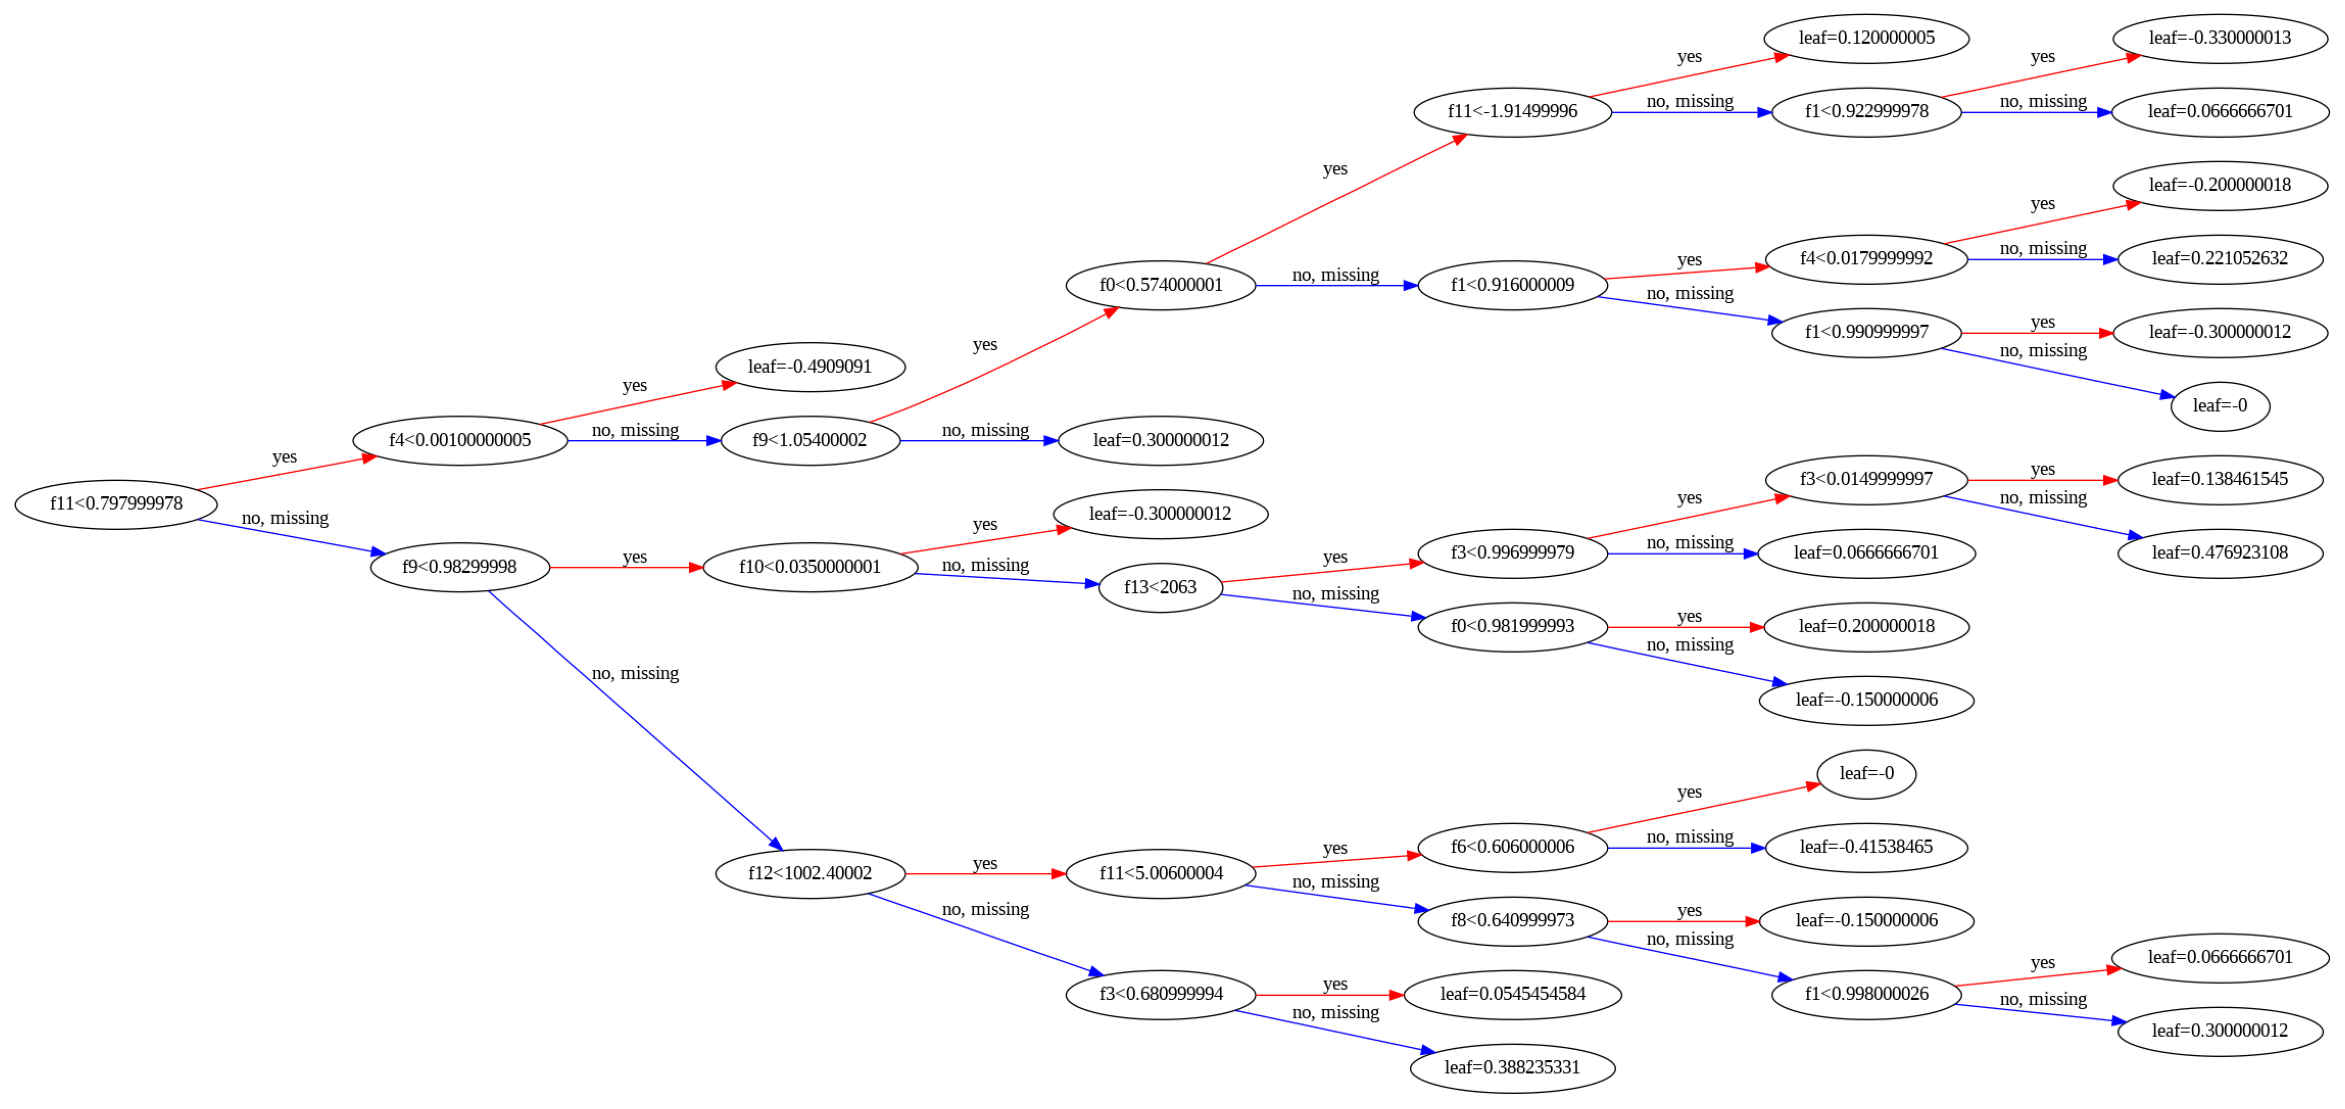

In [7]:
#Display results
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(classifier,rankdir='LR',ax=ax)

In [8]:
# Prepare dataset for hyperparameter tuning
from sklearn.model_selection import PredefinedSplit
X_tr1 = X_tr.tolist()
X_train1 = X_train.tolist()
split_index = [-1 if x in X_tr1 else 0 for x in X_train1]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [9]:
# Tuning the model with testing method 1:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
#from sklearn.model_selection import GridSearchCV
param_grid = {'gamma': [0.1,0.4,0.8,1.6,6.4],
        'min_child_weight': [1,100,150,200],
        'subsample': [0.4,0.6,0.8,1],
        'reg_lambda': [0,0.4,1.6,6.4],
        #'eta': [0.1,0.2,0.3,0.4], #default: 0.3
        #'sampling_method': ['uniform', 'gradient_based'],
        'grow_policy' : ['depthwise','lossguide'],
        }
search = HalvingGridSearchCV(classifier, param_grid, scoring = 'accuracy',
                      resource='n_estimators',
                      max_resources=1000,
                      cv = 4)#delete pds to gain more reliable results
search.fit(X_train,y_train)
print("Best Parameters:",search.best_params_)
print("Training Score:",search.best_score_)

Best Parameters: {'gamma': 1.6, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'reg_lambda': 1.6, 'subsample': 1, 'n_estimators': 972}
Training Score: 0.6825396825396826


In [10]:
print("Test Score:",search.score(X_test,y_test)) #Increase significantly (orginal: 62.35%)

Test Score: 0.6470588235294118


In [11]:
search.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

In [12]:
new_classifier = XGBClassifier(objective='binary:logistic',tree_method='hist')
#params = {'gamma': 6.4, 'grow_policy': 'depthwise', 'n_estimators': 50, 'reg_alpha': 0.4, 'reg_lambda': 1.6, 'sampling_method': 'uniform'}
new_classifier.set_params(**search.best_params_)
new_classifier.fit(X_train, y_train)
print("Training Accuray: {:.2f}%".format(100*new_classifier.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*new_classifier.score(X_test, y_test)))
y_pred = new_classifier.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print("Model AUC_ROC: {:.4f}".format(auc_score))

Training Accuray: 90.08%
Model Accuray: 64.71%
Model AUC_ROC: 0.6305


Supoport Vector Machine Idea: Lots of points get ignored in training.

##Conclusion for tuning
The results are more reliable since testing score is similar to training score.

In [ ]:
# Build training/testing sets 2
# This testing method gives better overview of the classifer
# as the early one has varied reuslts with different
# random states.
from sklearn.model_selection import LeaveOneOut
#define cross-validation method to use
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred1 = list(), list()
for train_ix, test_ix in cv.split(X):
 # split data
 X_train1, X_test1 = X[train_ix, :], X[test_ix, :]
 y_train1, y_test1 = Y[train_ix], Y[test_ix]
 # fit model
 model = XGBClassifier(objective='binary:logistic')
 model.fit(X_train1, y_train1)
 # evaluate model
 yhat = model.predict(X_test1)
 # store
 y_true.append(y_test1[0])
 y_pred1.append(yhat[0])
# calculate accuracy
acc = accuracy_score(y_true, y_pred1)
auc_score = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc))
#66.17% for all features
print("Model AUC_ROC: {:.4f}".format(auc_score))
#0.65 for all features

In [ ]:
#Display results
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model,rankdir='LR',ax=ax)

In [ ]:
# Build training/testing sets 2 - Hyperparameters Optimised
from sklearn.model_selection import LeaveOneOut
#define cross-validation method to use
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred11 = list(), list()
for train_ix, test_ix in cv.split(X):
 # split data
 X_train1, X_test1 = X[train_ix, :], X[test_ix, :]
 y_train1, y_test1 = Y[train_ix], Y[test_ix]
 # fit model
 new_classifier.fit(X_train1, y_train1)
 # evaluate model
 yhat = new_classifier.predict(X_test1)
 # store
 y_true.append(y_test1[0])
 y_pred11.append(yhat[0])
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred11)
auc_score1 = roc_auc_score(y_true, y_pred11)
print("Model Accuray: {:.2f}%".format(100*acc1))
#69.44%
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#0.6681

#Note the running time increases to 3 min!

In [ ]:
#Display results
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(new_classifier,rankdir='LR',ax=ax)

## Conlusion for Hyperparameter Tuning:
It might be the limit training groups that causes the low accuracy result;
hence tuninig the hyperparameter doesn't help for improving the accuracy (within controlled computational cost).